In [1]:
import datetime
import pathlib
import re

import shapely
import numpy as np
import pandas as pd
import dask.dataframe as dd

import slr.wind
import slr.psmsl
import slr

import xarray as xr
import matplotlib.pyplot as plt

# Create one series extended to 2022 and backwards to 1950
We have the current data up to 2021. Now we are going extend the data backwards. 

```
t: date time starting, with day of month 1 as representative date
name: station name long
psmsl_id: psmsl id (integer)
ddl_id: Data Distributie Laag id: string capitalized
latitude: lat of grid point in gtsm
longitude: lon of grid point in gtsm
station_name: station name/id in gtsm, string
surge: surge in meters
year: fractional year, start of the first month
```

We need this for all 6 tide gauges and for the extra station NL, the mean of the 6 tide gauges. 

In [2]:
export_columns = ['t', 'name', 'psmsl_id', 'ddl_id', 'latitude', 'longitude', 'station_name', 'surge', 'year']
export_annual_columns = ['t', 'name', 'ddl_id', 'surge']

In [3]:
# import from here
data_dir = pathlib.Path('~/data/gtsm').expanduser()
new_data_dir = data_dir / '2023' / 'monthly_means_surge' 

# get the old exports from the current directory
src_dir = slr.get_src_dir()

In [4]:


# we'll use the annual means as validation
annual_gtsm_df = pd.read_csv(
    src_dir
    / "data"
    / "deltares"
    / "gtsm"
    / "gtsm_surge_annual_mean_main_stations.csv",
    converters={"t": pd.to_datetime},
)
annual_gtsm_df = annual_gtsm_df.drop(columns=["Unnamed: 0"])
annual_gtsm_df["year"] = annual_gtsm_df.t.dt.year

monthly_gtsm_df = pd.read_csv(
    src_dir
    / "data"
    / "deltares"
    / "gtsm"
    / "gtsm_surge_monthly_mean_main_stations.csv",
    converters={"t": pd.to_datetime},
)
monthly_gtsm_df = monthly_gtsm_df.drop(columns=["Unnamed: 0"])
# compute year fraction
monthly_gtsm_df["year"] = [
    slr.utils.datetime2year(dt) for dt in monthly_gtsm_df["t"]
]
# remove the mean station
monthly_gtsm_df = monthly_gtsm_df.query('ddl_id != "NL"')

# we now have  monthly_gtsm_df and annual_gtsm_df. Both reflect the records as used by the previous SLR study
monthly_gtsm_df


,t,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge,year
0,1979-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.016918,1979.000000
1,1979-01-01,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,-0.041117,1979.000000
2,1979-01-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,-0.009794,1979.000000
3,1979-01-01,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,-0.012795,1979.000000
4,1979-01-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.011499,1979.000000
...,...,...,...,...,...,...,...,...,...
3091,2021-12-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,0.062967,2021.915068
3092,2021-12-01,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,0.076140,2021.915068
3093,2021-12-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,0.049677,2021.915068
3094,2021-12-01,IJmuiden,32.0,IJMDBTHVN,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...,0.061915,2021.915068


In [5]:
main_stations = slr.psmsl.get_main_stations()
main_stations

,name,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,gtsm_id,gtsm_id_2023,foundation_low,station_low,station_high,summary,img,nulpaal,links
id,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,NWS_NO_TS_MO_Vlissingen,39624,-17.6,2.50,9.00,This station is located at a quay in Vlissinge...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4068'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,NWS_NO_TS_MO_HoekVanHolland,39594,-3.3,5.27,9.05,The station in Hoek van Holland is located bes...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4021', 'length': 28.35, 'foot': -2...",[{'href': 'http://geodesy.unr.edu/NGLStationPa...
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,NWS_NO_TS_MO_DenHelder,39574,-5.0,5.00,8.47,This station is located in the dike of Den Hel...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4036', 'length': 17.5, 'foot': -12...",[]
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,NWS_NO_TS_MO_Delfzijl,39573,-20.0,1.85,10.18,The tidal measurement station in Delfzijl is l...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4041'},[{'href': 'http://geodesy.unr.edu/NGLStationPa...
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,NWS_NO_TS_MO_Harlingen,39585,-5.4,5.55,8.54,The tidal station in Harlingen is located in a...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4020', 'length': 28, 'foot': -22, ...",[]
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,NWS_NO_TS_MO_Ijmuiden,39600,-13.0,4.20,10.35,IJmuiden is located on the northern part of th...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4049'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...


In [6]:
# The new GTSM exports are missing the station information. They do include id's so we are able to match it.
# Here we'll add the ddl_id so that we can match it back later.

station_info_2022_df = monthly_gtsm_df.groupby(['name', 'psmsl_id', 'ddl_id', 'station_name']).first()[['latitude', 'longitude']].reset_index()
# mwege with main station info
main_stations = main_stations.merge(station_info_2022_df, left_on='ddl_id', right_on='ddl_id', suffixes=['', '_gtsm'])
# remove double columns
main_stations = main_stations.drop(columns=['name_gtsm', 'psmsl_id_gtsm'])

In [7]:
# gtsm uses numeric station id's that are consistent between two datasets
selected_stations = list(main_stations['gtsm_id_2023'])
selected_stations

[39624, 39594, 39574, 39573, 39585, 39600]

In [8]:
new_ds = xr.open_mfdataset(list(sorted(new_data_dir.glob('*.nc'))))
station_idx = np.isin(new_ds['stations'], selected_stations)

In [9]:
new_unmelted_df = new_ds['surge'][:, station_idx].to_pandas()
new_df = pd.melt(new_unmelted_df.reset_index(), id_vars=['time'], value_vars=selected_stations, var_name='gtsm_id_2023', value_name='surge')
new_df['t'] = new_df['time'].apply(lambda t: t.replace(day=1))
# add year similar to other dataset
new_df["year"] = [
    slr.utils.datetime2year(dt) for dt in new_df["t"]
]

new_df

,time,gtsm_id_2023,surge,t,year
0,1950-01-31,39624,-0.024607,1950-01-01,1950.000000
1,1950-02-28,39624,0.198269,1950-02-01,1950.084932
2,1950-03-31,39624,0.020684,1950-03-01,1950.161644
3,1950-04-30,39624,0.195034,1950-04-01,1950.246575
4,1950-05-31,39624,0.013280,1950-05-01,1950.328767
...,...,...,...,...,...
2443,2022-08-31,39600,-0.040714,2022-08-01,2022.580822
2444,2022-09-30,39600,0.066602,2022-09-01,2022.665753
2445,2022-10-31,39600,0.064123,2022-10-01,2022.747945
2446,2022-11-30,39600,0.075379,2022-11-01,2022.832877


In [10]:
# export these columns, consistent with old file
columns = ["t" , "year", "name", "psmsl_id", "ddl_id", "surge", 'latitude', 'longitude', 'station_name']
gtsm2023_df = pd.merge(main_stations, new_df, left_on='gtsm_id_2023', right_on='gtsm_id_2023')
gtsm2023_df = gtsm2023_df[columns]
# add old columns
gtsm2023_df

,t,year,name,psmsl_id,ddl_id,surge,latitude,longitude,station_name
0,1950-01-01,1950.000000,Vlissingen,20,VLISSGN,-0.024607,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...
1,1950-02-01,1950.084932,Vlissingen,20,VLISSGN,0.198269,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...
2,1950-03-01,1950.161644,Vlissingen,20,VLISSGN,0.020684,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...
3,1950-04-01,1950.246575,Vlissingen,20,VLISSGN,0.195034,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...
4,1950-05-01,1950.328767,Vlissingen,20,VLISSGN,0.013280,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...
...,...,...,...,...,...,...,...,...,...
2443,2022-08-01,2022.580822,IJmuiden,32,IJMDBTHVN,-0.040714,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...
2444,2022-09-01,2022.665753,IJmuiden,32,IJMDBTHVN,0.066602,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...
2445,2022-10-01,2022.747945,IJmuiden,32,IJMDBTHVN,0.064123,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...
2446,2022-11-01,2022.832877,IJmuiden,32,IJMDBTHVN,0.075379,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...


In [11]:
merged_df = pd.merge(monthly_gtsm_df, gtsm2023_df, left_on=['t', 'ddl_id'], right_on=['t', 'ddl_id'], how='outer', suffixes=['', '_2023']).sort_values('t')
# this is the old surge
for var in ['surge', 'name', 'station_name', 'psmsl_id', 'latitude', 'longitude', 'year']:
    merged_df[var] =  np.where(pd.isna(merged_df[var]), merged_df[var + '_2023'], merged_df[var])
    merged_df = merged_df.drop(columns=[var + '_2023'])
# computed during input
merged_df

,t,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge,year
3456,1950-01-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.016686,1950.000000
3816,1950-01-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,0.001298,1950.000000
4896,1950-01-01,IJmuiden,32.0,IJMDBTHVN,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...,-0.008331,1950.000000
3096,1950-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.024607,1950.000000
4176,1950-01-01,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.025930,1950.000000
...,...,...,...,...,...,...,...,...,...
4895,2022-12-01,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,0.097962,2022.915068
3455,2022-12-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.046922,2022.915068
3815,2022-12-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,0.059427,2022.915068
4175,2022-12-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,0.081649,2022.915068


In [12]:
monthly_complete_df = merged_df[['t', 'year', 'name', 'psmsl_id', 'ddl_id', 'latitude', 'longitude', 'station_name', 'surge']].copy()
monthly_complete_df

,t,year,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge
3456,1950-01-01,1950.000000,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.016686
3816,1950-01-01,1950.000000,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,0.001298
4896,1950-01-01,1950.000000,IJmuiden,32.0,IJMDBTHVN,52.461978,4.556043,b'NWS_NO_TS_MO_Ijmuiden\r ...,-0.008331
3096,1950-01-01,1950.000000,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.024607
4176,1950-01-01,1950.000000,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.025930
...,...,...,...,...,...,...,...,...,...
4895,2022-12-01,2022.915068,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,0.097962
3455,2022-12-01,2022.915068,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.046922
3815,2022-12-01,2022.915068,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,0.059427
4175,2022-12-01,2022.915068,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,0.081649


# Add the Dutch mean
We add Amersfoort as a center. We take th emean of all values. 

In [13]:
monthly_complete_df['month'] = monthly_complete_df['t'].dt.month
nl_monthly_mean_df = monthly_complete_df[['t', 'latitude', 'longitude', 'surge', 'year', 'month']].groupby(['t']).mean()[['latitude', 'longitude', 'surge', 'year', 'month']].reset_index()

nl_monthly_mean_df['station_name'] = 'Dutch mean'
nl_monthly_mean_df['name'] = 'NL'
nl_monthly_mean_df['ddl_id'] = 'NL'

olv_toren = shapely.geometry.Point(5.3850577, 52.1551995)
nl_monthly_mean_df['longitude'] = olv_toren.x
nl_monthly_mean_df['latitude'] = olv_toren.y
monthly_with_nl_df = pd.concat([monthly_complete_df, nl_monthly_mean_df])
monthly_with_nl_df = monthly_with_nl_df.sort_values(['ddl_id', 't'])
# we should now have a dataset from 1950 through 2022
monthly_with_nl_df

,t,year,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge,month
4176,1950-01-01,1950.000000,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.025930,1.0
4177,1950-02-01,1950.084932,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.266204,2.0
4178,1950-03-01,1950.161644,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.119336,3.0
4179,1950-04-01,1950.246575,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.239258,4.0
4180,1950-05-01,1950.328767,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,0.041548,5.0
...,...,...,...,...,...,...,...,...,...,...
3451,2022-08-01,2022.580822,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.029642,8.0
3452,2022-09-01,2022.665753,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.071214,9.0
3453,2022-10-01,2022.747945,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.025926,10.0
3454,2022-11-01,2022.832877,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.039806,11.0


Check that NL is in the middle of all other records.

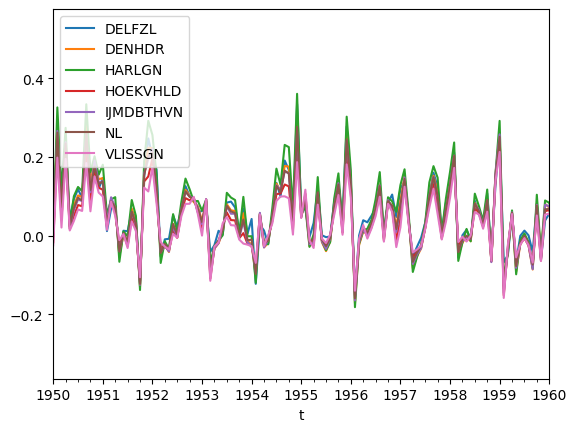

In [14]:
fig, ax = plt.subplots()

for ddl_id, df_i in monthly_with_nl_df.groupby('ddl_id'):
    df_i.plot('t', 'surge', ax=ax, label=ddl_id)
ax.set_xlim(datetime.datetime(1950, 1, 1), datetime.datetime(1960, 1, 1))
ax.legend(loc='upper left')

In [15]:
# groupby date
monthly_with_nl_df['days_in_year'] = np.where(monthly_with_nl_df.t.dt.is_leap_year, 366, 365)
monthly_with_nl_df['days_in_month'] = monthly_with_nl_df.t.dt.days_in_month
monthly_with_nl_df['year_part'] = (monthly_with_nl_df['days_in_month'] / monthly_with_nl_df['days_in_year'])
columns = [pd.Grouper(freq='AS'), 'name', 'ddl_id']
# surge * days per month / days per year (month fraction of year)
monthly_with_nl_df['surge_year_part'] = monthly_with_nl_df['surge'] * monthly_with_nl_df['year_part']
# if we sum fraction per year over months then we have mean surge over year, weighted by month lengths
annual_with_nl_df = monthly_with_nl_df.set_index('t').groupby(columns, dropna=False)[['surge_year_part']].sum().reset_index()
# rename column to surge
annual_with_nl_df = annual_with_nl_df.rename(columns={"surge_year_part": "surge"})
annual_with_nl_df['year'] = annual_with_nl_df['t'].dt.year
annual_with_nl_df = annual_with_nl_df.merge(main_stations, left_on='ddl_id', right_on='ddl_id', suffixes=['', '_2023'], how='left') 
annual_with_nl_df = annual_with_nl_df[export_columns]
annual_with_nl_df = annual_with_nl_df.sort_values(['ddl_id', 't'])
annual_with_nl_df.tail(n=10)

,t,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge,year
447,2013-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.011755,2013
454,2014-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.026838,2014
461,2015-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.032894,2015
468,2016-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.011976,2016
475,2017-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.041461,2017
482,2018-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.000784,2018
489,2019-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.034405,2019
496,2020-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.029433,2020
503,2021-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.017111,2021
510,2022-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,0.017516,2022


In [16]:
# validation: this should be true, all year parts should sum up to 1 per group
(monthly_with_nl_df.set_index('t').groupby(columns).sum()[['year_part']] == 1).all()

year_part    True
dtype: bool

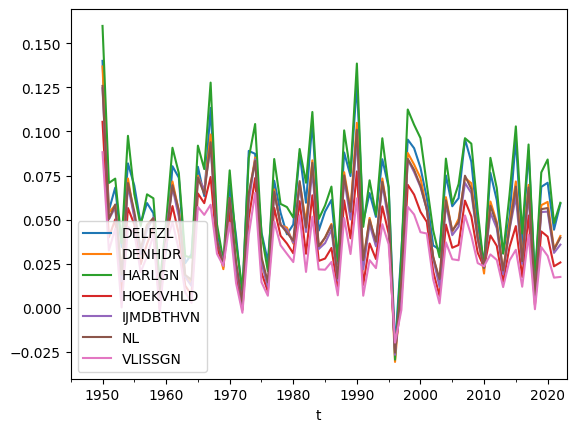

In [17]:
# check within range of -0.1, 0.3
fig, ax = plt.subplots()

for ddl_id, df_i in annual_with_nl_df.groupby('ddl_id'):
    df_i.plot('t', 'surge', ax=ax, label=ddl_id)
ax.set_xlim(datetime.datetime(1945, 1, 1), datetime.datetime(2023, 1, 1))
ax.legend(loc='lower left')


# Export

In [18]:
columns = ['t', 'name', 'psmsl_id', 'ddl_id', 'latitude', 'longitude', 'station_name', 'surge']
monthly_export_df = monthly_with_nl_df[columns]
annual_export_df = annual_with_nl_df[export_annual_columns]

In [19]:
annual_path = (
    src_dir
    / "data"
    / "deltares"
    / "gtsm"
    / "gtsm_surge_annual_mean_main_stations_2023.csv"
)
monthly_path = (
    src_dir
    / "data"
    / "deltares"
    / "gtsm"
    / "gtsm_surge_monthly_mean_main_stations_2023.csv"
)

In [20]:
monthly_export_df.to_csv(monthly_path)
annual_export_df.to_csv(annual_path)



# Check generated wind files

In [16]:
import datetime

import slr.wind
import matplotlib.pyplot as plt


In [17]:
monthly_gtsm_2022_df, annual_gtsm_2022_df = slr.wind.get_gtsm_dfs(version='2022', with_m=True)
monthly_gtsm_2023_df, annual_gtsm_2023_df = slr.wind.get_gtsm_dfs(version='2023', with_m=True)

Text(0, 0.5, 'surge [m]')

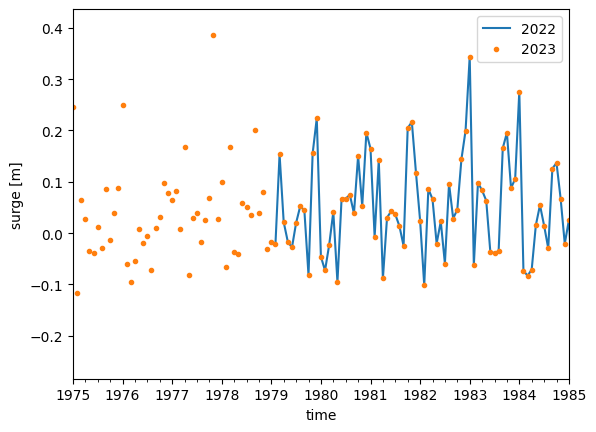

In [33]:
fig, ax = plt.subplots()

monthly_gtsm_2022_df.query(query).groupby('ddl_id').plot('t', 'surge', ax=ax, label='2022')
monthly_gtsm_2023_df.query(query).groupby('ddl_id').plot('t', 'surge', style='.', ax=ax, label='2023')
ax.set_xlim(datetime.datetime(1975, 1, 1), datetime.datetime(1985, 1, 1))
ax.set_xlabel('time')
ax.set_ylabel('surge [m]')


# Check updated gtsm exports
We are now checking the updated dataset from 2023-10-23. This dataset consists of all surge and waterlevels. 

In [ ]:
data_dir = pathlib.Path('~/data/gtsm').expanduser()
list(data_dir.glob('**/era5_reanalysis_surge*2019*.nc'))

In [ ]:
new_path = data_dir / '2023/monthly_means_surge/era5_reanalysis_surge_2019_v1_monthly_mean.nc'

In [ ]:
old_paths = list(sorted((data_dir / '2018/surge').glob('era5_reanalysis_surge_2019*.nc')))

In [ ]:
ds = xr.open_dataset(old_paths[0])

def last_day_of_month(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - datetime.timedelta(days=next_month.day)
    
def add_time_dim(ds):
    path_re = re.compile(r'era5_reanalysis_surge_(?P<year>\d+)_(?P<month>\d+)_v1_monthly_mean.nc')
    match = path_re.search(ds.encoding['source'])
    year = int(match.group('year'))
    month = int(match.group('month'))
    time = datetime.datetime(year, month, 1)
    # new dataset contains dates with last day of month, let's keep it consistent
    result = ds.expand_dims(time=[last_day_of_month(time)])
    return result

In [ ]:
old_ds = xr.open_mfdataset(old_paths, preprocess = add_time_dim)

In [ ]:
new_ds = xr.open_dataset(new_path)
new_ds

In [ ]:
old_stations_df = old_ds['stations'].to_dataframe()

def clean_name(name):
    return name.decode('utf-8').strip()
old_stations_idx = old_stations_df['station_name'].apply(clean_name).isin(main_stations.index)
old_stations_idx.sum()

In [ ]:
selected_stations_old = old_stations_df[old_stations_idx]
selected_stations_old

In [ ]:
new_stations_df = new_ds[['station_x_coordinate', 'station_y_coordinate']].to_dataframe()
# manual found station Hoek van Holland
fig, ax = plt.subplots()
new_ds.sel(stations=39624).surge.plot(ax=ax)
old_ds.sel(stations=39624).surge.plot(ax=ax, linestyle='-.')

In [ ]:
fig, ax = plt.subplots()
old_ds.surge[:, old_stations_idx].to_dataframe().reset_index().groupby('station_name').plot('time', 'surge', ax=ax)

In [ ]:
new_ds

In [ ]:
new_ds

# Checks with dataset that did not validate correctly.

In [ ]:
data_dir = pathlib.Path('~/src/sealevel/data/deltares/gtsm/era5-long').expanduser()
data_dir.exists()

In [ ]:
mean_files = list(sorted(data_dir.glob('**/*mean*.csv')))

In [ ]:
monthly_gtsm_df, annual_gtsm_df = slr.wind.get_gtsm_dfs()
annual_gtsm_df

In [ ]:
# Check with Natalia Aleksandrova if we can also derive monthly data
# Last time we got netcdf's in the form of:
# reanalysis_surge_10min_2018_12_v1_monthly_mean.nc
# Can we reuse the same datasets?

In [ ]:
main_stations = slr.psmsl.get_main_stations()
main_stations = main_stations.set_index('gtsm_id')

In [ ]:
# tijd column
# name
# id -> ddl_id


In [ ]:
path = mean_files[-3]

path_re = re.compile(r'Stations_NL_(?P<year>\d{4})_mean.csv$')


mean_dfs = []
for path in mean_files:
    match = path_re.search(str(path))
    year_str = match.group('year')
    year = int(year_str)
    mean_df_i = pd.read_csv(path)
    mean_df_i = mean_df_i.rename(
        columns={
            year_str: "gtsm_id", 
            "0": "surge_mm"
        }
    )
    t = datetime.datetime(year, 1, 1)
    # TODO: is the data in m?
    mean_df_i['surge_mm'] *= 1000
    # add column to start of dataframe
    mean_df_i['t'] = t
    mean_df_i['year'] = year
    mean_dfs.append(mean_df_i)
mean_df = pd.concat(mean_dfs)



In [ ]:
mean_df['ddl_id'] = mean_df.apply(lambda row: main_stations.loc[row['gtsm_id']]['ddl_id'], axis=1)
mean_df['name'] = mean_df.apply(lambda row: main_stations.loc[row['gtsm_id']]['name'], axis=1)
columns = ['t', 'name', 'ddl_id', 'year', 'surge_mm']
mean_df = mean_df[columns]

In [ ]:
merged = pd.merge(annual_gtsm_df, mean_df, left_on=['year', 'ddl_id'], right_on=['year', 'ddl_id'], suffixes=('_2022', '_2023'))
merged

In [ ]:
ax = merged.plot('surge_mm_2022', 'surge_mm_2023', style='.')
ax.set_xlabel('Surge from SLR monitor 2022 [mm]')
ax.set_ylabel('Surge from new data for 2023 [m => mm?]')

In [ ]:
mean_df.groupby('year').mean(numeric_only=True).plot()